# single-label vs multi-label

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/07 16:45:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/07 16:45:37 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Fri Mar  7 04:45:42 PM EST 2025


In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/parquet/"

# Define the path to the train and test parquet files
train_path = f"{data_path}/train"
test_path = f"{data_path}/test"

# Read the parquet files into a spark DataFrame
train_df = spark.read.parquet(train_path)
test_df = spark.read.parquet(test_path)

# Show the data
train_df.show(n=5)
test_df.show(n=5)

+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------+--------------------+
|          image_name|                path|                data|organ|species_id|    obs_id|             license|partner|          author|altitude|         latitude|         longitude|gbif_species_id|             species|        genus|    family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pla-B3-201907...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-E5-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B1-20140...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-D4-201507...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-F3-20190...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [5]:
import matplotlib.pyplot as plt
from plantclef.serde import deserialize_image
from pyspark.sql import functions as F

# filter test dataframe
test_image = "CBN-Pyr-03-20230706.jpg"
test_df = test_df.where(F.col("image_name") == test_image).cache()
test_df.show()

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pyr-03-202307...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
+--------------------+--------------------+--------------------+



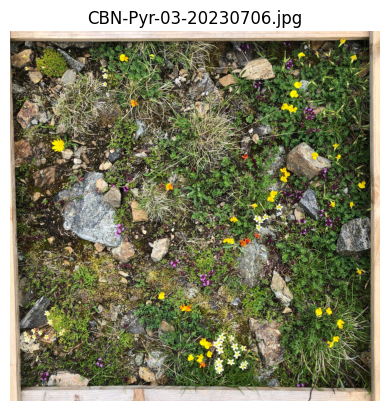

In [6]:
test_image_data = test_df.select("data").collect()[0][0]
original_image = deserialize_image(test_image_data)

plt.imshow(original_image)
plt.title(test_image)
plt.axis("off")
plt.show()

In [7]:
from pyspark.sql.window import Window

# select subset of train_df
limit_df = train_df.limit(500)
window = Window().partitionBy("image_name").orderBy("image_name")
df_with_row_num = limit_df.withColumn("row_num", F.row_number().over(window))

In [9]:
begin, end = 0, 100
subset_df = df_with_row_num.filter(F.col("row_num").between(begin, end)).collect()
img = subset_df[0]["data"]
type(img)

bytearray

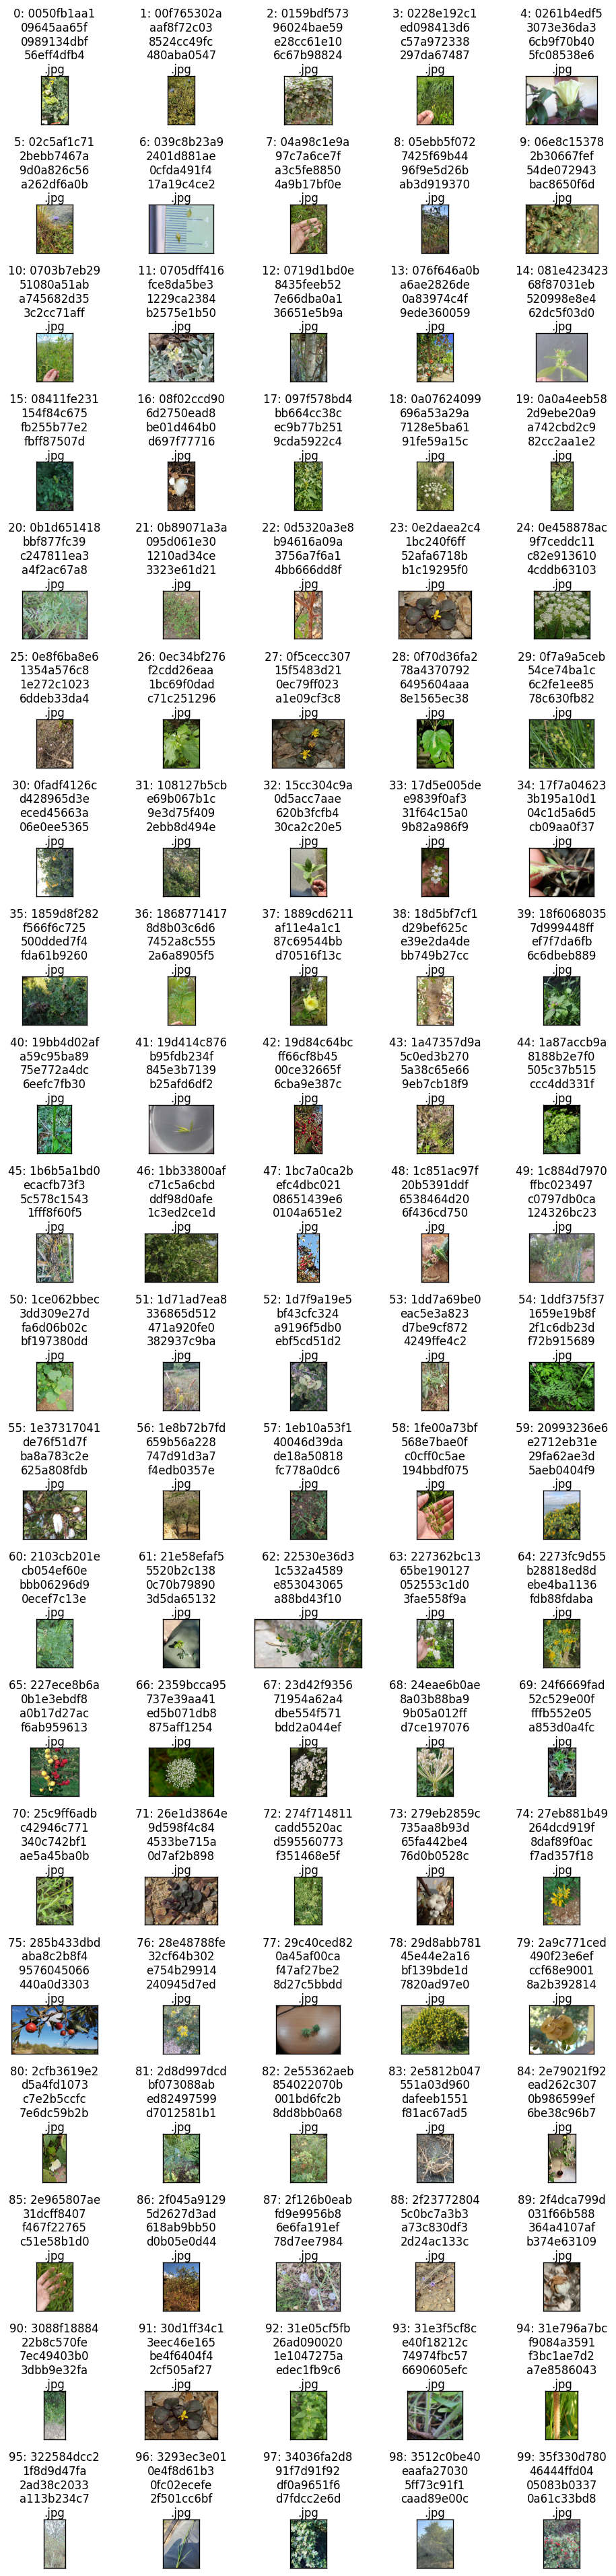

In [17]:
import textwrap
import numpy as np

fig, axes = plt.subplots(20, 5, figsize=(8, 32), dpi=120)

img_data_list = [row["data"] for row in subset_df]
img_name_list = [row["image_name"] for row in subset_df]

# flatten the axes array for easy iteration if it's 2D
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for idx, (ax, img_data, img_name) in enumerate(zip(axes, img_data_list, img_name_list)):
    img = deserialize_image(img_data)
    ax.imshow(img)
    wrapped_name = "\n".join(textwrap.wrap(img_name, width=10))
    ax.set_title(f"{idx}: {wrapped_name}", fontsize=10, pad=1)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [30]:
# image_subset = img_name_list[3, 31, 55, 92, 93]
img_dict = {idx: name for idx, name in enumerate(img_name_list)}
indexes = [24, 59, 66, 67]
selected_image_names = [name for idx, name in img_dict.items() if idx in indexes]
selected_image_names

# with open("train_image_names.txt", "w") as f:
#     for line in selected_image_names:
#         f.write(f"{line}\n")

['0e458878ac9f7ceddc11c82e9136104cddb63103.jpg',
 '20993236e6e2712eb31e29fa62ae3d5aeb0404f9.jpg',
 '2359bcca95737e39aa41ed5b071db8875aff1254.jpg',
 '23d42f935671954a62a4dbe554f571bdd2a044ef.jpg']